<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/01-intro/DataHandling_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Please, fill in before you start:

First Name: Alexander

Last Name: Glushko

Group: MIIAD22

### After the assigment is done, please, push it to a [private GitHub repository](https://docs.github.com/en/github/administering-a-repository/managing-repository-settings/setting-repository-visibility) and invite [Majid-Sohrabi](https://github.com/Majid-Sohrabi), [abdalazizrashid](https://github.com/abdalazizrashid) [as collaborators](https://docs.github.com/en/account-and-profile/setting-up-and-managing-your-github-user-account/managing-access-to-your-personal-repositories/inviting-collaborators-to-a-personal-repository).

Get the Titanic dataset:

In [1]:
# !wget https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv

In [2]:
import pandas as pd
data = pd.read_csv("train.csv", index_col='PassengerId')
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### About the data
Here's some of the columns
* Name - a string with person's full name
* Survived - 1 if a person survived the shipwreck, 0 otherwise.
* Pclass - passenger class. Pclass == 3 is cheap'n'cheerful, Pclass == 1 is for moneybags.
* Sex - a person's gender
* Age - age in years, if available
* SibSp - number of siblings on a ship
* Parch - number of parents on a ship
* Fare - ticket cost
* Embarked - port where the passenger embarked
 * C = Cherbourg; Q = Queenstown; S = Southampton

## Task 1 (1 point)

In [3]:
# Compute survival rate for each of the three passenger classes (`Pclass` = 1, 2 and 3)
# (can you do it using groupby?)

data[['Pclass', 'Survived']].groupby('Pclass').mean().round(2)

,Survived
Pclass,
1,0.63
2,0.47
3,0.24


## Task 2 (1 point)

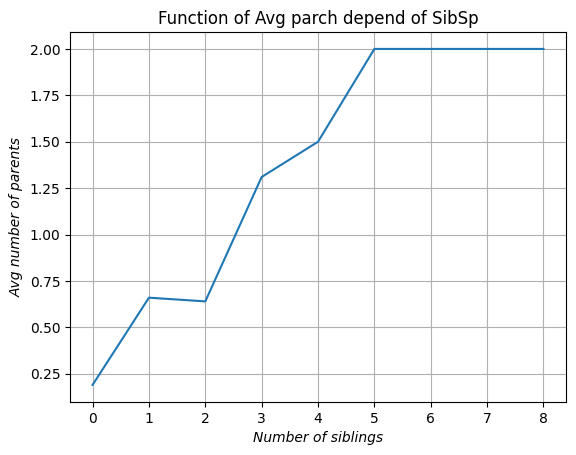

In [4]:
# Plot the average number of parents onboard (`Parch`) as a function of the
# number of siblings onboard (`SibSp`)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.gca()
ax.set_xlabel("Number of siblings", style='italic')
ax.set_ylabel("Avg number of parents", style='italic')
ax.set_title("Function of Avg parch depend of SibSp")
ax.grid()
plt.plot(data[['Parch', 'SibSp']].groupby('SibSp').mean().round(2))


## Task 3 (2 points)

In [5]:
import numpy as np

class KNeighborsClassifier():
    def __init__(self, n_neighbors: int):
        self.n_neighbors = n_neighbors

    def fit(self, X: pd.DataFrame, y: pd.DataFrame) -> None:
        self.X_train = X
        self.y_train = y

    def predict(self, X: pd.DataFrame) -> np.array:
        prediction = []
        train_sum = np.sum(self.X_train ** 2, axis=1)
        test_sum = np.sum(X ** 2, axis=1)

        distances = train_sum[: np.newaxis] + test_sum - 2 * (self.X_train @ X.T)

        for i in range(len(X)):
            curr_idx_distances = distances[:,i]
            sorted_index = np.argsort(curr_idx_distances)
            top_k_index = sorted_index[:self.n_neighbors]
            label, votes = np.unique(self.y_train[top_k_index], return_counts=True)
            prediction.append(label[np.argmax(votes)])

        return np.array(prediction)


In [6]:
# Build a model with KNeighborsClassifier to get the accuracy of
# at least 0.75 on the validation part of the dataset

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def feature_selection_and_preprocessing(dataset: pd.DataFrame):
    features = dataset.copy()
    features = features.drop(["Name", "Ticket", "Cabin", "SibSp", 'Age'], axis=1)
    features = features.replace({'Sex': {'male': 0, 'female': 1}})
    features = features.replace({'Embarked': {'S': 0, 'C': 1, 'Q': 2}})
    features['Embarked'] = features['Embarked'].fillna(features['Embarked'].median())
    features = (features-features.mean())/features.std()
    return features

model = KNeighborsClassifier(n_neighbors=1)


# Validation code (do not touch)
data = pd.read_csv("train.csv", index_col='PassengerId')
data_train = data.iloc[:-100]
data_test = data.iloc[-100:]

model.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ),
    data_train['Survived']
)

test_predictions = model.predict(
    feature_selection_and_preprocessing(
        data_test.drop('Survived', axis=1)
    )
)
print("Test accuracy:", accuracy_score(
    data_test['Survived'],
    test_predictions
))

Test accuracy: 0.82


## Task 4 (2 points)

Check how your model from the previous task performs on randomized splits to train / test (with test set of size 100). Plot the histogram of the test error distribution.

*Hint: check sklearn's `sklearn.model_selection.train_test_split` function.*

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = feature_selection_and_preprocessing(data.drop('Survived', axis=1))
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=42)

model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(f"Model accuracy: {accuracy_score(y_test, predictions)}")

Model accuracy: 0.73


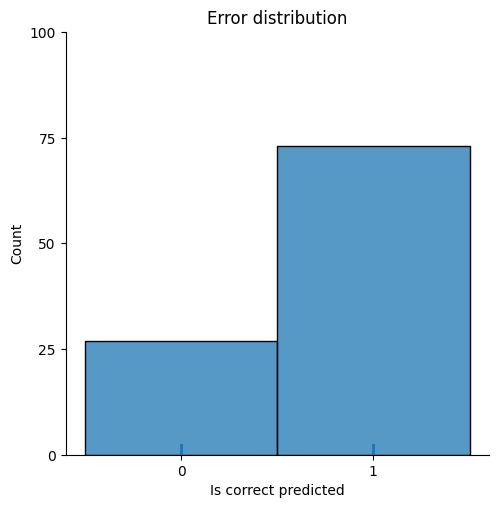

In [8]:
import seaborn as sns

g = sns.displot(data=predictions == y_test, discrete=True, rug=True, legend=True)
g.ax.set_xticks([0, 1])
g.ax.set_yticks(range(0, 125, 25))
g.ax.set_xlabel("Is correct predicted")
g.ax.set_title("Error distribution")
g

In [9]:
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(f"Model accuracy: {accuracy_score(y_test, predictions)}")

Model accuracy: 0.8


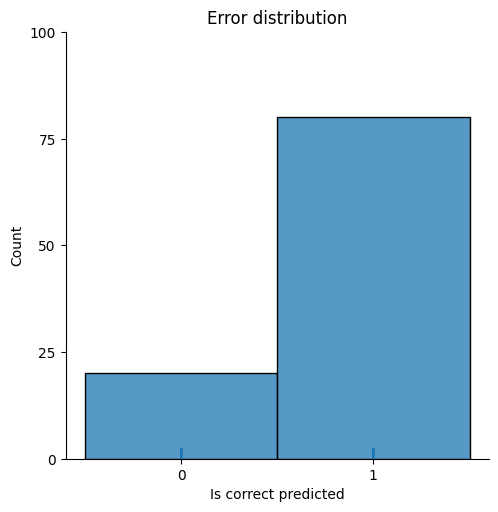

In [10]:
import seaborn as sns

g = sns.displot(data=predictions == y_test, discrete=True, rug=True, legend=True)
g.ax.set_xticks([0, 1])
g.ax.set_yticks(range(0, 125, 25))
g.ax.set_xlabel("Is correct predicted")
g.ax.set_title("Error distribution")
g